# Quantum Shor's algorithm

Here is the quantum version of the shor's algorithm that we called in the main runner file. This is a borrowed implemenation from <a href="https://github.com/mett29/Shor-s-Algorithm?tab=readme-ov-file">here</a>. The implementation begins with the classical part and then implements the quantum functions. I leave it to future work to integrate these methods directly into the primarily notebook given the modular nature of Shor's algorithm. 

P.S. This would replace **Step 4** in the factorize function within shor.ipynb.

### Classical Part 

We implemented a similar version of this for our main runner code, but for simplicity, we keep the implementation that the author of this work built. 

In [15]:
# basic imports
import math
import random
import sys
from fractions import Fraction
from builtins import input
import numpy as np
import timeit
import matplotlib.pyplot as plt

# qiskit imports
from qiskit.providers.basic_provider import BasicProvider
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram

def shor(N, attempts = 1):
    
    # build compilation engine list
    rule_set = DecompositionRuleSet(modules=[projectq.libs.math,
                                             projectq.setups.decompositions])
    compilerengines = [AutoReplacer(rule_set),
                       InstructionFilter(high_level_gates),
                       TagRemover(),
                       LocalOptimizer(3),
                       AutoReplacer(rule_set),
                       TagRemover(),
                       LocalOptimizer(3)]

    # make the compiler and run the circuit on the simulator backend
    eng = MainEngine(Simulator(), compilerengines)
    
    for attempt in range(attempts):
        print("-----------------------------------")
        print("\nAttempt #" + str(attempt))
        
        x = random.randint(0, N)
        print("Random x between 0 and N-1 --> ", str(x))
        
        '''If the GCD is not 1, x is a nontrivial factor of N, so we're done'''
        if (math.gcd(x, N) != 1):
            print("\nFactors found classically, re-attempt...")
            continue
        
        '''Otherwise it means that x and N are coprime
        Here the quantum part starts: Shor's algorithm tries to find r, the period of x^a mod n, where n is 
        the number to be factored and x is an integer coprime to n.
        It is important to underline the r  is the smallest positive integer such that x^r = 1 mod N
        '''
        r = find_period(eng, N, x, verbose=False)
        
        '''If r is odd or if x^r/2 = -1 (mod N), choose another x
        EXPLANATION: we already know that x^r/2 is NOT congruent to 1 (mod N), otherwise the order of x would be r/2,
        instead of r. So we have to check only that x^r/2 is NOT congruent to -1 (mod N)
        '''
        if ((r % 2 != 0) or (pow(x, int(r/2), N) == -1)): 
            print("r is odd or x^r/2 = -1 (mod N), re-attempt...")
            continue
            
        print("\nPeriod found: " + str(r))
        
        p = math.gcd(x**int(r / 2) + 1, N)
        q = math.gcd(x**int(r / 2) - 1, N)
        
        if ((not p * q == N) and p * q > 1 and int(1. * N / (p * q)) * p * q == N):
            p, q = p * q, int(N / (p * q))
        if p * q == N and p > 1 and q > 1:
            print("\nFactors found: {} * {} = {}.".format(p, q, N))
            break
        else:
            print("\nBad luck: Found {} and {}".format(p, q))

#### Qiskit circuit example with N = 15

One of the primary challenges of quantum implementations of classical algorithms is that as we design the quantum circuit to solve this factoring challenge, the circuit we must design changes as the input size scales. A 5-10 qubit system to solve a low input size challenge would take extraordinarily long to compute hence is impractical. Anyways here we hardcode some of these quantum gate operations for the value 15 hence making it a non-scalable system. 

In [16]:
# This short circuit is the controlled unitary operation
def circuit_2mod15(qc,qr,cr):
    qc.cswap(qr[4],qr[3],qr[2])
    qc.cswap(qr[4],qr[2],qr[1])
    qc.cswap(qr[4],qr[1],qr[0])

In [17]:
def circuit_aperiod15(qc,qr,cr,a):
    
    # Initialize q[0] to |1> 
    qc.x(qr[0])

    # Apply a**4 mod 15
    # ------------------
    qc.h(qr[4])
    # Controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    qc.h(qr[4])
    # Measure quantum bit into classical bit
    qc.measure(qr[4],cr[0])
    # Reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a**2 mod 15
    # ------------------
    qc.h(qr[4])
    # Controlled unitary: cx(self, ctl, tgt),
    # apply CX from ctl to tgt
    qc.cx(qr[4],qr[2])
    qc.cx(qr[4],qr[0])
    # Feed forward / U1 gate allows to apply a quantum phase, while 'c_if' adds a classical control register
    qc.p(math.pi/2., qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    # Measure
    qc.measure(qr[4],cr[1])
    # Reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a mod 15
    # ------------------
    qc.h(qr[4])
    # Controlled unitary
    circuit_2mod15(qc,qr,cr)
    # Feed forward
    qc.p(3.*math.pi/4.,qr[4]).c_if(cr, 3)
    qc.p(math.pi/2.,qr[4]).c_if(cr, 2)
    qc.p(math.pi/4.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    # Measure
    qc.measure(qr[4],cr[2])

In [18]:
def quantum_shor():
    # we use 5 qubits for this implementation
    q = QuantumRegister(5, 'q')
    c = ClassicalRegister(5, 'c')

    shor = QuantumCircuit(q, c)
    circuit_aperiod15(shor,q,c,2)
    shor.draw(output='mpl') # use this to draw quantum circuit if desired.

    backend = BasicProvider().get_backend('basic_simulator')
    sim_result = backend.run([shor]).result()
    sim_data = sim_result.get_counts(shor) 
    plot_histogram(sim_data) # use this to visualize simulation data if desired

    r=2
    a = int(max(sim_data, key=sim_data.get), 2)
    factor1 = np.gcd(int(a**(r/2) -1), 15)
    factor2 = np.gcd(int(a**(r/2) +1), 15)

    # print with robustness against (5, 1) type integer factorizations
    if factor1 == 1: 
        print("\n factor 1: ", int(15/factor2), " and factor 2: ", factor2)
    else:
        print("\n factor 1: ", factor1, " and factor 2: ", int(15/factor1))

In [19]:
print("\n The time factoring n=15 took was: ", timeit.timeit(quantum_shor, globals=globals(), number=1), " seconds.")


 factor 1:  15  and factor 2:  1

 The time factoring n=15 took was:  0.3350983749842271  seconds.


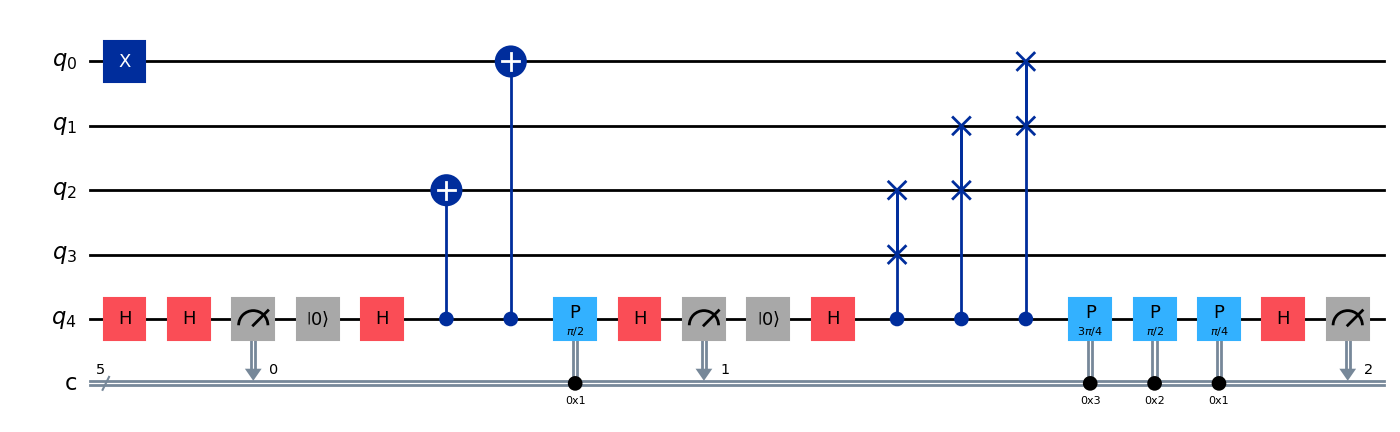

In [20]:
q = QuantumRegister(5, 'q')
c = ClassicalRegister(5, 'c')

shor = QuantumCircuit(q, c)
circuit_aperiod15(shor,q,c,2)
shor.draw(output='mpl') # use this to draw quantum circuit if desired.

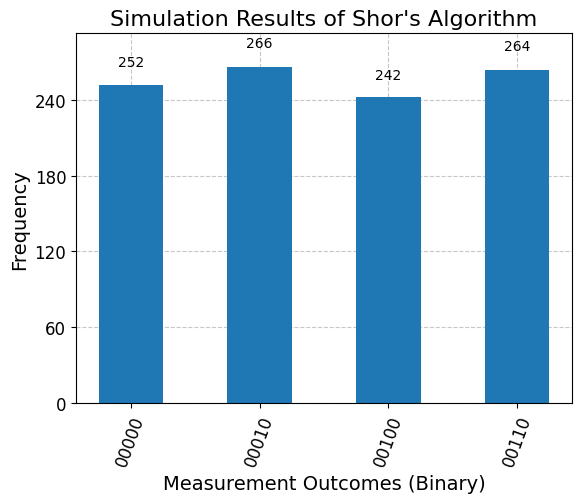

In [21]:
backend = BasicProvider().get_backend('basic_simulator')
sim_result = backend.run([shor]).result()
sim_data = sim_result.get_counts(shor) 
plot_histogram(sim_data) # use this to visualize simulation data if desired

# Plot histogram
fig, ax = plt.subplots()
plot_histogram(sim_data, ax=ax)

# Adding labels and title
ax.set_xlabel('Measurement Outcomes (Binary)', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Simulation Results of Shor\'s Algorithm', fontsize=16)

# Customize the plot to make it "pretty"
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, linestyle='--', alpha=0.7)

plt.show()